# Challenge Description

We got employee data from a few companies. We have data about all employees who joined from 2011-01-24 to 2015-12-13. For each employee, we also know if they are still at the company as of 2015-12-13 or they have quit. Beside that, we have general info about the employee, such as avg salary during her tenure, dept, and yrs of experience.

As said above, the goal is to predict employee retention and understand its main drivers. Specifically, you should:


1. Assume, for each company, that the headcount starts from zero on 2011-01-23. Estimate employee headcount, for each company on each day, from 2011-01-24 to 2015-12-13. That is, if by 2012-03-02 2000 people have joined company 1 and 1000 of them have already quit, then company headcount on 2012-03-02 for company 1 would be 1000. You should create a table with 3 columns: day, employee_headcount, company_id
2. What are the main factors that drive employee churn? Do they make sense? Explain your findings
3. If you could add to this data set just one variable that could help explain employee churn, what would that be?

# Data Description

- **employee_id:** id of the employee. Unique by employee per company
- **company_id:** company id. It is unique by company
- **dept:** employee dept
- **seniority:** number of yrs of work experience when hired
- **salary:** avg yearly salary of the employee during her tenure within the company
- **join_date:** when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13
- **quit_date:** when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

# Navigation
<a href='#Exploration'>Link</a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/bundickm/DataMasked/main/CSVs/employee_retention.csv?token=ALJ4RG2M3GHCTKWESVW3A3C73PF5C')

print(df.shape)
df.head()

(24702, 7)


,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24702 entries, 0 to 24701
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   employee_id  24702 non-null  float64
 1   company_id   24702 non-null  int64  
 2   dept         24702 non-null  object 
 3   seniority    24702 non-null  int64  
 4   salary       24702 non-null  float64
 5   join_date    24702 non-null  object 
 6   quit_date    13510 non-null  object 
dtypes: float64(2), int64(2), object(3)
memory usage: 1.3+ MB


<a id='Exploration'></a>
# Initial Exploration

In [ ]:
df['join_date'] = pd.to_datetime(df['join_date'])
df['quit_date'] = pd.to_datetime(df['quit_date'])

In [ ]:
df.describe()

,employee_id,company_id,seniority,salary
count,24702.000000,24702.000000,24702.000000,24702.000000
mean,501604.403530,3.426969,14.127803,138183.345478
std,288909.026101,2.700011,8.089520,76058.184573
min,36.000000,1.000000,1.000000,17000.000000
25%,250133.750000,1.000000,7.000000,79000.000000
50%,500793.000000,2.000000,14.000000,123000.000000
75%,753137.250000,5.000000,21.000000,187000.000000
max,999969.000000,12.000000,99.000000,408000.000000


Need to make a table of headcounts to address question 1. Quick and dirty nested loops to get the employee counts at any given date.

In [ ]:
dates = pd.date_range(start='2011/01/24', end='2015/12/13')
employee_counts = []
company_list = []
date_list = []

for company in df['company_id'].unique():
    for i, date in enumerate(dates):
        total_joined = len(df[(df['join_date'] <= date) & 
                              (df['company_id'] == company)])
        total_quit = len(df[(df['quit_date'] <= date) & 
                            (df['company_id'] == company)])
        employee_counts.append(total_joined - total_quit)
        company_list.append(company)
        date_list.append(date)
headcount_table = pd.DataFrame({'date': date_list, 'company_id': company_list,
                                'count': employee_counts})

In [ ]:
headcount_table[headcount_table['company_id'] == 3].head()

,date,company_id,count
14280,2011-01-24,3,9
14281,2011-01-25,3,10
14282,2011-01-26,3,12
14283,2011-01-27,3,12
14284,2011-01-28,3,12


In [ ]:
df['employment_length'] = (df['quit_date'] - df['join_date']).astype('timedelta64[D]')
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0


We see that employees are more likely to quit near their hire anniversary.

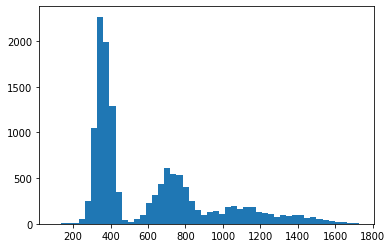

In [ ]:
plt.hist(df['employment_length'].dropna(), bins=50)
plt.show()

In [ ]:
def early_quit(employment_length, join_date, max_date):
    if (join_date + pd.Timedelta(days=395)) > max_date:
        return np.NaN
    elif (employment_length > 395):
        return 0.0
    return 1.0

df['early_quit'] = np.vectorize(early_quit)(df['employment_length'], df['join_date'], max(df['join_date']))

In [ ]:
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date,employment_length,early_quit
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30,585.0,0.0
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04,340.0,1.0
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT,NaN,1.0
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07,389.0,1.0
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22,1040.0,0.0


Exploring causes for the turn over for all companies

In [ ]:
for col in ['company_id', 'dept', 'seniority', 'salary', 'join_date', 'quit_date']:
    print(df.groupby(col)['early_quit'].mean().sort_values())
    print()

company_id
9     0.573351
5     0.578909
3     0.586272
10    0.590977
7     0.591048
1     0.597323
2     0.597708
4     0.601356
6     0.606719
8     0.617073
11    0.625000
12    0.809524
Name: early_quit, dtype: float64

dept
design              0.581670
marketing           0.583129
data_science        0.588562
customer_service    0.596674
engineer            0.597781
sales               0.612645
Name: early_quit, dtype: float64

seniority
99    0.000000
98    0.000000
12    0.560759
15    0.565460
17    0.568483
8     0.571429
5     0.575800
23    0.575908
25    0.578853
19    0.580913
21    0.581994
6     0.588391
20    0.589443
27    0.590000
11    0.591292
16    0.593039
7     0.593220
2     0.593915
10    0.603352
14    0.604196
22    0.606957
9     0.608333
24    0.608919
26    0.609756
3     0.610526
13    0.612392
1     0.613095
28    0.622222
29    0.625000
18    0.632035
4     0.638849
Name: early_quit, dtype: float64

salary
370000.0    0.0
375000.0    0.0
363000.0    0.

In [ ]:
salary_ranges = pd.cut(df['salary'], 30)
salary_table = pd.crosstab(salary_ranges, df['early_quit'],
                           margins=True, dropna=False)

salary_table[0.0] = salary_table[0.0] / salary_table['All']
salary_table[1.0] = salary_table[1.0] / salary_table['All']

salary_table

early_quit,0.0,1.0,All
salary,,,
"(16609.0, 30033.333]",0.294859,0.490786,1031
"(30033.333, 43066.667]",0.273923,0.476077,836
"(43066.667, 56100.0]",0.308145,0.474975,1019
"(56100.0, 69133.333]",0.322906,0.450050,1982
"(69133.333, 82166.667]",0.318857,0.474437,1819
"(82166.667, 95200.0]",0.318713,0.464327,1710
"(95200.0, 108233.333]",0.307257,0.458569,1943
"(108233.333, 121266.667]",0.326861,0.441748,1854
"(121266.667, 134300.0]",0.328096,0.461345,1591


In [ ]:
dept_table = pd.crosstab(df['dept'], df['early_quit'],
                           margins=True, dropna=False)

dept_table[0.0] = dept_table[0.0] / dept_table['All']
dept_table[1.0] = dept_table[1.0] / dept_table['All']

dept_table

early_quit,0.0,1.0,All
dept,,,
customer_service,0.311765,0.461220,9180
data_science,0.324765,0.464577,3190
design,0.334058,0.464493,1380
engineer,0.314329,0.467158,4613
marketing,0.321440,0.449637,3167
sales,0.305170,0.482661,3172
All,0.315561,0.464213,24702


In [ ]:
comp_table = pd.crosstab(df['company_id'], df['early_quit'],
                           margins=True, dropna=False)

comp_table[0.0] = comp_table[0.0] / comp_table['All']
comp_table[1.0] = comp_table[1.0] / comp_table['All']

comp_table

early_quit,0.0,1.0,All
company_id,,,
1,0.315461,0.467947,8486
2,0.307674,0.457129,4222
3,0.320116,0.453619,2749
4,0.313773,0.473327,2062
5,0.329915,0.453561,1755
6,0.308288,0.475600,1291
7,0.328431,0.474673,1224
8,0.299904,0.483286,1047
9,0.329865,0.443288,961


In [ ]:
join_table = pd.crosstab(join_ranges, df['early_quit'],
                         margins=True, dropna=False)
join_table[0.0] = join_table[0.0] / join_table['All']
join_table[1.0] = join_table[1.0] / join_table['All']

join_table

early_quit,0.0,1.0,All
join_date,,,
"(2011-01-22 05:15:21.600000, 2011-03-24 08:48:00]",0.703349,0.296651,836
"(2011-03-24 08:48:00, 2011-05-22 17:36:00]",0.700680,0.299320,735
"(2011-05-22 17:36:00, 2011-07-21 02:24:00]",0.701934,0.298066,879
"(2011-07-21 02:24:00, 2011-09-18 11:12:00]",0.681818,0.318182,792
"(2011-09-18 11:12:00, 2011-11-16 20:00:00]",0.614961,0.385039,909
"(2011-11-16 20:00:00, 2012-01-15 04:48:00]",0.603316,0.396684,784
"(2012-01-15 04:48:00, 2012-03-14 13:36:00]",0.570634,0.429366,899
"(2012-03-14 13:36:00, 2012-05-12 22:24:00]",0.530864,0.469136,810
"(2012-05-12 22:24:00, 2012-07-11 07:12:00]",0.525219,0.474781,912


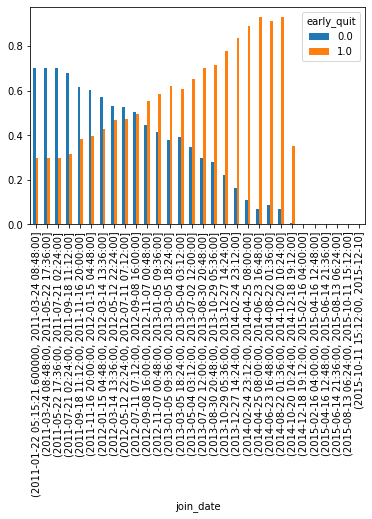

In [ ]:
join_table.drop('All').drop('All', axis='columns').plot.bar()

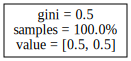

In [ ]:
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
data_dummy = pd.get_dummies(df[['company_id', 'dept', 'seniority', 'salary', 'early_quit']], drop_first=True)           
data_dummy = data_dummy.dropna()

tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf = 10, class_weight="balanced", min_impurity_decrease = 0.001)
tree.fit(data_dummy.drop('early_quit', axis=1), data_dummy['early_quit'])
  
#visualize it
export_graphviz(tree, out_file="tree_employee.dot", feature_names=data_dummy.drop('early_quit', axis=1).columns, proportion=True, rotate=True)
with open("tree_employee.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_employee.dot")
s

In [ ]:
data_dummy

,company_id,seniority,salary,early_quit,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,7,28,89000.0,0.0,0,0,0,0,0
1,7,20,183000.0,1.0,0,0,0,1,0
2,4,14,101000.0,1.0,0,0,0,1,0
3,7,20,115000.0,1.0,0,0,0,0,0
4,2,23,276000.0,0.0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
24695,1,5,172000.0,0.0,1,0,0,0,0
24696,6,7,88000.0,1.0,0,0,0,1,0
24699,4,11,67000.0,0.0,0,0,0,0,0
24700,10,98,266000.0,0.0,0,0,1,0,0
